# NMODL to Python conversion for Jaxley (Notebook)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Poirazi-Lab/DendroTweaks/blob/main/docs/source/tutorials/convert_to_jaxley.ipynb)

This notebook demonstrates how to convert channel models from NEURON MOD files to Jaxley-compatible Python classes. 

We will use the `MODFileConverter` class to convert Na and Kv channels using a Jinja template (`jaxley.py`). These channels will be added to a simple Jaxley point-neuron model to demonstrate the simulation. 

Note that while this notebook provides a working example, the template implementation is currently under development. In particular, handling equilibrium potentials (currently hardcoded) and the temperature adjustment coefficient tadj will likely be improved in a future version.

If you experience any problems parsing your MOD files with DendroTweaks, please refer to the documentation page https://dendrotweaks.readthedocs.io/en/latest/tutorials/tutorial_mod.html#. If the problem persists, feel free to contact us.

In [ ]:
!pip install jaxley --quiet

In [ ]:
!pip install dendrotweaks --quiet

If you are using Google Colab, you might also need to restart the session as the installation downgraded some packages (numpy). You can do it manually or programmatically as shown below:

In [ ]:
# import os
# os.kill(os.getpid(), 9)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import dendrotweaks as dd
dd.__version__

'0.4.4'

In [7]:
os.makedirs('examples', exist_ok=True)
if not os.listdir('examples/'):
    print("Downloading example data...")
    dd.download_example_data('examples')

Extracting relevant folders to examples...
Data downloaded and extracted successfully to examples/.


## Converting channels

In [ ]:
from dendrotweaks.biophys.io import MODFileConverter

In [2]:
converter = MODFileConverter()

In [ ]:
path_to_mod_file = os.path.join('examples', 'Toy', 'biophys', 'mod', 'Na.mod')
path_to_python = os.path.join('examples', 'Toy', 'biophys', 'python', 'Najx.py')
path_to_template = os.path.join('examples', 'Templates', 'jaxley.py')

In [ ]:
converter.convert(path_to_mod_file, path_to_python, path_to_template);

Saved content to /home/roman/Documents/code/DendroTweaksLab/DendroTweaks/examples/Toy/biophys/python/Najx.py


In [19]:
with open(path_to_python, 'r') as f:
    code = f.read()
    print(code[:500])  # Print the first 500 characters of the generated code
    print("...")

# This Python channel class was automatically generated from a MOD file
# using DendroTweaks toolbox, dendrotweaks.dendrites.gr


from jaxley.channels import Channel
from jaxley.solver_gate import exponential_euler
import jax.numpy as np

class Kv(Channel):
    """
    Kv_Park_ref
    """

    def __init__(self, name="Kv"):
        self.current_is_in_mA_per_cm2 = True
        super().__init__(name=name)
        self.channel_params = {
            "gbar_Kv": 0.0,
            "Ra_Kv": 0.02,
      
...


In [ ]:
path_to_mod_file = os.path.join('examples', 'Toy', 'biophys', 'mod', 'Kv.mod')
path_to_python = os.path.join('examples', 'Toy', 'biophys', 'python', 'Kvjx.py')
path_to_template = os.path.join('examples', 'Templates', 'jaxley.py')

In [ ]:
converter.convert(path_to_mod_file, path_to_python, path_to_template);

Saved content to /home/roman/Documents/code/DendroTweaksLab/DendroTweaks/examples/Toy/biophys/python/Kvjx.py


## Setting up a model

In [7]:
import jaxley as jx

In [ ]:
from examples.Toy.biophys.python.Najx import Na
from examples.Toy.biophys.python.Kvjx import Kv
from jaxley.channels import Leak

In [9]:
cell = jx.Cell()  # Define cell.

temperature = 37.0

na = Na()
kv = Kv()
na.set_tadj(temperature)
kv.set_tadj(temperature)
print(na.tadj, kv.tadj)

cell.insert(na)
cell.insert(kv)
cell.insert(Leak())

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


3.2093639532679714 3.2093639532679714


In [10]:
cell.nodes.columns

Index(['local_cell_index', 'local_branch_index', 'local_comp_index', 'length',
       'radius', 'axial_resistivity', 'capacitance', 'v', 'global_cell_index',
       'global_branch_index', 'global_comp_index', 'controlled_by_param', 'Na',
       'gbar_Na', 'Rma_Na', 'Rmb_Na', 'v12m_Na', 'qm_Na', 'Rhb_Na', 'Rha_Na',
       'v12ha_Na', 'v12hb_Na', 'qh_Na', 'v12hinf_Na', 'qhinf_Na', 'temp_Na',
       'q10_Na', 'm_Na', 'h_Na', 'Kv', 'gbar_Kv', 'Ra_Kv', 'Rb_Kv', 'v12_Kv',
       'q_Kv', 'temp_Kv', 'q10_Kv', 'n_Kv', 'Leak', 'Leak_gLeak',
       'Leak_eLeak'],
      dtype='object')

In [11]:
cell.nodes['Leak_eLeak']

0   -70.0
Name: Leak_eLeak, dtype: float64

In [12]:
cell.set('gbar_Na', 0.05)
cell.set('gbar_Kv', 0.01)
cell.set('length', 20)
cell.set('radius', 10)
cell.set('Leak_gLeak', 0.0003)
cell.set('axial_resistivity', 100)
cell.set('capacitance', 1.0)

## Running a simulation

In [13]:
current = jx.step_current(i_delay=100.0, i_dur=100.0, i_amp=0.1, delta_t=0.025, t_max=300.0)
cell.stimulate(current)  # Stimulate with step current.
cell.record("v")  # Record voltage.

Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.


Text(0.5, 1.0, 'Somatic Action Potentials')

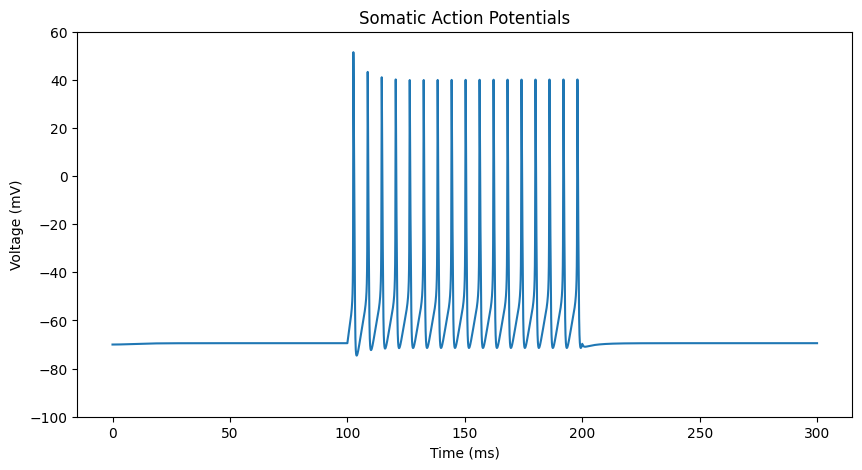

In [14]:
v = jx.integrate(cell, delta_t=0.025, t_max=300.0)  # Run simulation.
t = np.arange(0, 300, 0.025)  # Create time vector.
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t, v.T[:-1]) 
ax.set_ylim(-100, 60)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('Somatic Action Potentials')